# Summary
<p>
My solution of the code along. I did not use the solution.<br>
My main problem: limited computing resources make the hyperparameter tuning tedious.<br>
As an esemble methods in particular the number of trees parameter promises better predictions.<br>
This increases the computational challenge.<br>
I provided several param grids for hyperparameter tuning, but apply only those with few parameters.<br>
Otherwise the computations would take to long.<br>
However the bigger params grid can easily inserted as variables.<br>
It shows that adding processing power with cloud computing makes sense in machine learning.
</p>

<p>
It is advisable to save models in particular, when the training costs are extensive.
A good overview is given here on Medium:<br> 
<a href="https://medium.datadriveninvestor.com/machine-learning-how-to-save-and-load-scikit-learn-models-d7b99bc32c27" target="_blank">machine-learning-how-to-save-and-load-scikit-learn-models</a> 
</p>

<p>
I added several methods to the code along like:
</p>
   
<ul>
  <li>Classes</li> 
  <li>error visualizations</li>
  <li>Gridsearch</li>
  <li>Pipelines</li>
  <li>Cross validation</li>
  <li>Dmatrix with the XGBoost learning API</li>
</ul> 

# **Machine Learning with XGboost in Python**

Welcome to this code-along, where we will use XGBoost to predict booking cancellations with gradient boosting, a powerful machine learning technique! Through this, you'll learn how to create, evaluate, and tune XGBoost models efficiently. There will be time to answer any questions, so please add them!

## **The Dataset**

The session's dataset is a CSV file named `hotel_bookings_clean.csv`, which contains data on hotel bookings. 

### **Acknowledgements**
The dataset was downloaded on [Kaggle](https://www.kaggle.com/jessemostipak/hotel-booking-demand/). The data is originally from an article called [Hotel booking demand datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) by Nuno Antonio, Ana de Almeida, and Luis Nunes. It was then cleaned by Thomas Mock and Antoine Bichat for [#TidyTuesday during the week of February 11th, 2020](https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md). For the purposes of this code-along, it was further pre-processed to have cleaner ready-to-use features (e.g., dropping irrelevant columns, one-hot-encoding). The dataset has the following [license](https://creativecommons.org/licenses/by/4.0/).

### **Data Dictionary**

It contains the **53 columns**:

_For binary variables: `1` = true and `0` = false._

#### **Target** 
- `is_canceled`: Binary variable indicating whether a booking was canceled

#### **Features** 
- `lead time`: Number of days between booking date and arrival date
- `arrival_date_week_number`, `arrival_date_day_of_month`, `arrival_date_month`: Week number, day date, and month number of arrival date 
- `stays_in_weekend_nights`, `stays_in_week_nights`: Number of weekend nights (Saturday and Sunday) and weeknights (Monday to Friday) the customer booked
- `adults`,`children`,`babies`: Number of adults, children, babies booked for the stay
- `is_repeated_guest`: Binary variable indicating whether the customer was a repeat guest 
- `previous_cancellations`: Number of prior bookings that were canceled by the customer
- `previous_bookings_not_canceled`: Number of prior bookings that were not canceled by the customer
- `required_car_parking_spaces`: Number of parking spaces requested by the customer
- `total_of_special_requests`: Number of special requests made by the customer
- `avg_daily_rate`: Average daily rate, as defined by dividing the sum of all lodging transactions by the total number of staying nights
- `booked_by_company`: Binary variable indicating whether a company booked the booking
- `booked_by_agent`: Binary variable indicating whether an agent booked the booking
- `hotel_City`: Binary variable indicating whether the booked hotel is a "City Hotel"
- `hotel_Resort`: Binary variable indicating whether the booked hotel is a "Resort Hotel"
- `meal_BB`: Binary variable indicating whether a bed & breakfast meal was booked 
- `meal_HB`: Binary variable indicating whether a half board meal was booked
- `meal_FB`: Binary variable indicating whether a full board meal was booked 
- `meal_No_meal`: Binary variable indicating whether there was no meal package booked 
- `market_segment_Aviation`, `market_segment_Complementary`, `market_segment_Corporate`, `market_segment_Direct`, `market_segment_Groups`, `market_segment_Offline_TA_TO`, `market_segment_Online_TA`, `market_segment_Undefined`: Indicates market segment designation with a value of `1`. "TA"= travel agent, "TO"= tour operators
- `distribution_channel_Corporate`, `distribution_channel_Direct`, `distribution_channel_GDS`, `distribution_channel_TA_TO`, `distribution_channel_Undefined`: Indicates booking distribution channel with a value of `1`. "TA"= travel agent, "TO"= tour operators, "GDS" = Global Distribution System
- `reserved_room_type_A`,`reserved_room_type_B`, `reserved_room_type_C`,`reserved_room_type_D`, `reserved_room_type_E`, `reserved_room_type_F`, `reserved_room_type_G`, `reserved_room_type_H`, `reserved_room_type_L`: Indicates code of room type reserved with a value of `1`. Code is presented instead of designation for anonymity reasons
- `deposit_type_No_Deposit`: Binary variable indicating whether a deposit was made
- `deposit_type_Non_Refund`: Binary variable indicating whether a deposit was made in the value of the total stay cost
- `deposit_type_Refundable`: Binary variable indicating whether a deposit was made with a value under the total stay cost 
- `customer_type_Contract`: Binary variable indicating whether the booking has an allotment or other type of contract associated to it 
- `customer_type_Group`: Binary variable indicating whether the booking is associated to a group 
- `customer_type_Transient`: Binary variable indicating whether the booking is not part of a group or contract, and is not associated to other transient booking
- `customer_type_Transient-Party`: Binary variable indicating whether the booking is transient, but is associated to at least another transient booking

---


## **1. Getting to know our data**

Let's get to know our columns and split our data into features and labels!

In [1]:
# Import libraries
import pandas as pd
import xgboost as xgb # XGBoost typically uses the alias "xgb"
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import joblib

In [2]:
# Read in the dataset

bookings = pd.read_csv("hotel_bookings_clean.csv")
# List out our columns
bookings.columns.tolist()

['is_canceled',
 'lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'arrival_date_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'avg_daily_rate',
 'booked_by_company',
 'booked_by_agent',
 'hotel_City',
 'hotel_Resort',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_No_meal',
 'market_segment_Aviation',
 'market_segment_Complementary',
 'market_segment_Corporate',
 'market_segment_Direct',
 'market_segment_Groups',
 'market_segment_Offline_TA_TO',
 'market_segment_Online_TA',
 'market_segment_Undefined',
 'distribution_channel_Corporate',
 'distribution_channel_Direct',
 'distribution_channel_GDS',
 'distribution_channel_TA_TO',
 'distribution_channel_Undefined',
 'reserved_room_type_A',
 'reserved_room_type_B',
 'reserved_room_type_C',
 'reserved_room_type_D',
 'reserved_ro

It looks like we have 53 columns with 119,210 rows. All the datatypes are numeric and ready for use.

In [3]:
# Take a closer look at column distributions
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119210 entries, 0 to 119209
Data columns (total 53 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   is_canceled                     119210 non-null  int64  
 1   lead_time                       119210 non-null  int64  
 2   arrival_date_week_number        119210 non-null  int64  
 3   arrival_date_day_of_month       119210 non-null  int64  
 4   arrival_date_month              119210 non-null  int64  
 5   stays_in_weekend_nights         119210 non-null  int64  
 6   stays_in_week_nights            119210 non-null  int64  
 7   adults                          119210 non-null  int64  
 8   children                        119206 non-null  float64
 9   babies                          119210 non-null  int64  
 10  is_repeated_guest               119210 non-null  int64  
 11  previous_cancellations          119210 non-null  int64  
 12  previous_booking

In [4]:
bookings.describe()


,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
count,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119206.000000,119210.000000,...,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000,119210.000000
mean,0.370766,104.109227,27.163376,15.798717,6.552051,0.927053,2.499195,1.859206,0.104047,0.007961,...,0.017549,0.005042,0.000050,0.876277,0.122364,0.001359,0.034158,0.004815,0.750575,0.210452
std,0.483012,106.875450,13.601107,8.781070,3.089796,0.995117,1.897106,0.575186,0.398842,0.097509,...,0.131305,0.070825,0.007094,0.329266,0.327707,0.036839,0.181636,0.069223,0.432682,0.407631
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,16.000000,8.000000,4.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,69.000000,28.000000,16.000000,7.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,161.000000,38.000000,23.000000,9.000000,2.000000,3.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,737.000000,53.000000,31.000000,12.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
bookings.head()

,is_canceled,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0,342,27,1,7,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,737,27,1,7,0,0,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,7,27,1,7,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,13,27,1,7,0,1,1,0.0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,14,27,1,7,0,2,2,0.0,0,...,0,0,0,1,0,0,0,0,1,0


In [6]:
# Plot cancellation counts to visualize proportion of not cancelled and cancelled
print(bookings['is_canceled'].value_counts())

0    75011
1    44199
Name: is_canceled, dtype: int64


In [7]:
print(bookings['is_canceled'].value_counts(normalize=True))

0    0.629234
1    0.370766
Name: is_canceled, dtype: float64


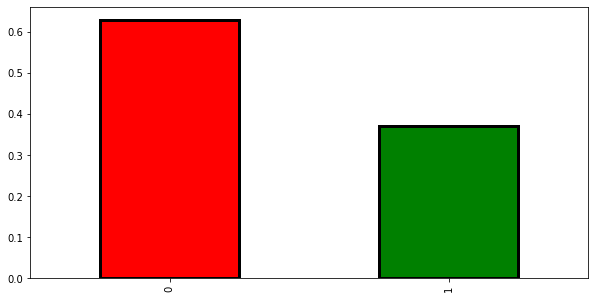

In [8]:
bookings['is_canceled'].value_counts(normalize=True).plot(kind='bar', edgecolor='black',
                                                          linewidth=3, color=['r', 'g'],
                                                          figsize=(10,5))
plt.show()

Remember for our binary variables, like `is_canceled`, `1` = true and `0` = false.

In [9]:
# Get an exact percentage of not cancelled and cancelled
print("Exact percentage - % - of not cancelled and cancelled")
print(round(bookings['is_canceled'].value_counts(normalize=True)*100, 4))

Exact percentage - % - of not cancelled and cancelled
0    62.9234
1    37.0766
Name: is_canceled, dtype: float64


### **Splitting data**
Let's split our label and features so we can get to building models! The first column is our target label `is_canceled`. The rest are features.

In [10]:
# Define X and y
y = bookings.loc[:, 'is_canceled']
print(y[:10])

X = bookings.drop(labels=['is_canceled'], axis=1)
X[:2]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    1
9    1
Name: is_canceled, dtype: int64


,lead_time,arrival_date_week_number,arrival_date_day_of_month,arrival_date_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,deposit_type_No_Deposit,deposit_type_Non_Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,342,27,1,7,0,0,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,737,27,1,7,0,0,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [11]:
y_gridsearch = y.copy()
X_gridsearch = X.copy()

## **2. Your First XGBoost Classifier**

XGBoost has a  [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn), which is useful if you want to use different scikit-learn classes and methods on an XGBoost model (e.g.,`predict()`, `fit()`).  In this section, we'll try the API out with the `xgboost.XGBClassifier()` class and get a baseline accuracy for the rest of our work. So that our results are reproducible, we'll set the `random_state=123`.

As a reminder, gradient boosting sequentially trains weak learners where each weak learner tries to correct its predecessor's mistakes. First, we'll instantiate a simple XGBoost classifier without changing any of the other parameters, and we'll inspect the parameters that we haven't touched.

In [12]:
from sklearn.model_selection import train_test_split

# Train and test split using sklearn
X_train, X_test, y_train, y_test = \
train_test_split(X,y, random_state=43, test_size=0.25)
print(X_train.shape)
print(y_train.shape)

# Instatiate a XGBClassifier 
bookings_xgb_clf = \
xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.35, learning_rate=0.01,
                 max_depth=6, alpha = 10, n_estimators = 15)

# Inspect the parameters
bookings_xgb_clf

(89407, 52)
(89407,)


XGBClassifier(alpha=10, base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.35, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=15, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)

There's a couple of things to note:
- The `booster` parameter is `gbtree`.  This means the weak learners, or boosters, are decision trees in this model. `gbtree` is the default, and we will keep it this way.
- The `objective` function, or loss function, is defined as `binary:logistic`. The objective function quantifies how far off a prediction is from the actual results. We want to minimize this to have the smallest possible loss. `binary:logistic` is the default for classifiers. `binary:logistic` outputs the actual predicted probability of the positive class (in our case, that a booking is cancelled).
- `n_estimators` is the number of gradient boosted trees we want in our model. It's equivalent to the number of boosting rounds. For our purposes, we don't want too many boosting rounds, or training will take too long. **Let's lower it from 100 to 10**.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/n_estimators.png?raw=true" width = "70%"> 
</p>

<br>

- `max_depth` is the maximum tree depth allowed. Tree depth is the length of the longest path from the root node to a leaf node. Making this too high will give our model more variance, or more potential to overfit. Similar to `n_estimators`, the more we increase this, the longer our training period will be. **Let's keep this at 3**.


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "25%"> 
</p>

- For our `eval_metric` (evaluation metric for validation data), we will use `error` as defined by [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):

> Binary classification error rate. It is calculated as #(wrong cases)/#(all cases). For the predictions, the evaluation will regard the instances with prediction value larger than 0.5 as positive instances, and the others as negative instances.

In [13]:
## Set n_estimators to 10 
n_estimators = 10 

## Set max_depth to 3
max_depth = 3

# Set the evaluation metric to error
eval_metric = 'logloss'

# Instatiate a XGBClassifier 
bookings_xgb_clf_2 = \
xgb.XGBClassifier(objective='binary:logistic', colsample_bytree=0.35, learning_rate=0.01,
                 max_depth=max_depth, alpha = 10, n_estimators = n_estimators, 
                 eval_metric='error'
                 )

# Fit it to the training set
bookings_xgb_clf_2.fit(X_train, y_train)

# Predict the labels of the test set
preds_2 = bookings_xgb_clf_2.predict(X_test)

In [14]:
print(type(preds_2))
print(preds_2.shape)
print(preds_2[:15])


<class 'numpy.ndarray'>
(29803,)
[0 0 1 0 1 1 1 1 0 0 0 0 1 0 0]


In [15]:
print(y_test[:5])
print(y_train[:5])

96298    0
88654    0
51468    1
5193     0
49741    1
Name: is_canceled, dtype: int64
72300     1
25818     0
116068    0
59564     1
5025      0
Name: is_canceled, dtype: int64


In [16]:
print(y_test.shape)
print(y_train.shape)

(29803,)
(89407,)


In [17]:
pred_2_df = \
pd.DataFrame(zip(y_test, preds_2), columns=['y_test', 'pred_2'])

pred_2_df.head()

,y_test,pred_2
0,0,0
1,0,0
2,1,1
3,0,0
4,1,1


#### Is y-test correctly predicted?


In [18]:
def correct_predictions(row, pred):
    if row['y_test'] == row[pred]:
        value = 1
    else:
        value = 0
    return value

In [19]:
pred_2_df['Correctly predicted?'] = \
pred_2_df.apply(correct_predictions, args=['pred_2'],  axis=1)

pred_2_df.head()

,y_test,pred_2,Correctly predicted?
0,0,0,1
1,0,0,1
2,1,1,1
3,0,0,1
4,1,1,1


In [20]:
pred_2_df['Correctly predicted?'].value_counts()

1    22842
0     6961
Name: Correctly predicted?, dtype: int64

In [21]:
round(pred_2_df['Correctly predicted?'].value_counts(normalize=True)*100)

1    77.0
0    23.0
Name: Correctly predicted?, dtype: float64

<p>Correctly prediced are 77 percent.<br>
This is above random predictions of 50%.
</p>

In [22]:
accuracy_byhand = round(pred_2_df['Correctly predicted?'].sum() / pred_2_df.shape[0],4)

print(f'Accuracy based on correctly predicted col of df is {accuracy_byhand}')

Accuracy based on correctly predicted col of df is 0.7664


We are going to use **accuracy** as our metric for this problem since we only have two classes, and the smallest class takes ~37% of the data. To calculate accuracy, we need to count the correctly predicted data points and divide it by the total number of data points.

In [23]:
# Calculate the accuracy
acc_1 = accuracy_score(y_test, preds_2, normalize=True, sample_weight=None)

# Print the baseline accuracy
print(acc_1)

0.7664329094386472


#### Creating a base learner using DMatrix with the XGBoost Learning API

<p>
Data Matrix used in XGBoost.<br>
DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data.<br>
<a href="https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.core" target="_blank">xgboost.readthedocs</a> 
</p>

In [24]:
book_DM_train = xgb.DMatrix(data=X_train, label=y_train)
book_DM_test = xgb.DMatrix(data=X_test, label=y_test)


# binary:hinge: hinge loss for binary classification. 
# This makes predictions of 0 or 1, rather than producing probabilities.
params_DM={'booster':'gbtree', 'max_depth': 2, 'eta': 1, 'objective': 'binary:hinge'}


book_tree = xgb.train(params=params_DM, dtrain=book_DM_train, num_boost_round=10)

book_DM_test_labels = book_DM_test.get_label()
print(book_DM_test_labels)

book_tree_preds = book_tree.predict(book_DM_test, output_margin=False,  ntree_limit=10)
book_tree_preds


[0. 0. 1. ... 0. 0. 1.]


array([0., 0., 1., ..., 0., 0., 1.], dtype=float32)

In [25]:
joblib.dump(bookings_xgb_clf_2 , 'bookings_xgb_clf_2.sav')

['bookings_xgb_clf_2.sav']

#### DMatrix properties

In [26]:
book_DM_train.feature_names[:4]

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'arrival_date_month']

In [27]:
book_DM_train.feature_types[:4]

['int', 'int', 'int', 'int']

In [28]:
print(book_DM_train.get_base_margin())
print(book_DM_train.get_label())
print(book_DM_train.get_weight())
print(book_DM_train.num_col())
print(book_DM_train.num_row())

[]
[1. 0. 0. ... 0. 0. 0.]
[]
52
89407


In [29]:
list(np.arange(10,21,1))

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [30]:
book_DM_train_sliced = book_DM_train.slice(list(np.arange(10,21,1)))

print(book_DM_train_sliced.num_col())
print(book_DM_train_sliced.num_row())

52
11


In [31]:
book_tree_preds_df = \
pd.DataFrame(zip(y_test, book_tree_preds), columns=['y_test', 'book_tree_preds'])

book_tree_preds_df['congruity'] = \
book_tree_preds_df.apply(lambda row: 1 if row['y_test'] == row['book_tree_preds'] else 0, axis=1)

print(book_tree_preds_df.shape)
book_tree_preds_df.head()

(29803, 3)


,y_test,book_tree_preds,congruity
0,0,0.0,1
1,0,0.0,1
2,1,1.0,1
3,0,0.0,1
4,1,1.0,1


In [32]:
book_tree_preds_df.tail()

,y_test,book_tree_preds,congruity
29798,1,0.0,0
29799,1,0.0,0
29800,0,0.0,1
29801,0,0.0,1
29802,1,1.0,1


In [33]:
for i in book_tree_preds_df:
    print(book_tree_preds_df[i].value_counts())

0    18738
1    11065
Name: y_test, dtype: int64
0.0    25622
1.0     4181
Name: book_tree_preds, dtype: int64
1    22839
0     6964
Name: congruity, dtype: int64


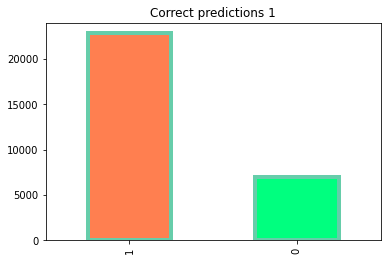

In [34]:
book_tree_preds_df.iloc[:,2].value_counts().plot(kind='bar', color=['coral', 'springgreen'],
                                                 edgecolor='mediumaquamarine', linewidth=4,
                                                 title="Correct predictions 1")
plt.show()

In [35]:
acc_dmatrix = accuracy_score(y_test, book_tree_preds)
acc_dmatrix

0.7663322484313659

### **Visualizing your tree**

`XGBoost` has two handy visualization functions for interpreting results.

The first is `plot_importance()`  which plots feature importance, meaning, how predictive each feature is for the target variable. It takes in the fitted XGBoost model.


#### **Plotting feature importance**

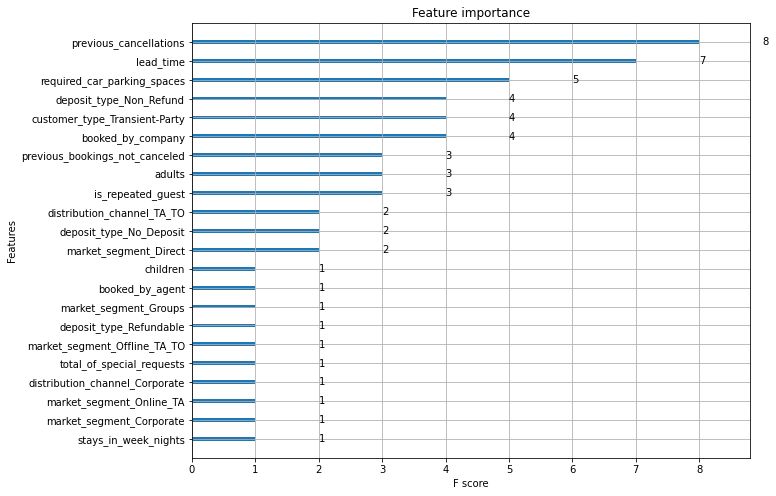

In [36]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8)

# Plot feature importance
# ”weight” is the number of times a feature appears in a tree
xgb.plot_importance(bookings_xgb_clf_2, importance_type='weight')
plt.show()

How is importance calculated? Here's an excerpt from the [documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.plotting):

> **importance_type (str, default "weight") –**
> How the importance is calculated: either “weight”, “gain”, or “cover”
> - ”weight” is the number of times a feature appears in a tree
> - ”gain” is the average gain of splits which use the feature
> - ”cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

We'll focus on the first two. Gain is a way to quantify how much a feature contributes to improving accuracy. Let's try out `gain` to see how it differs from `weight`.

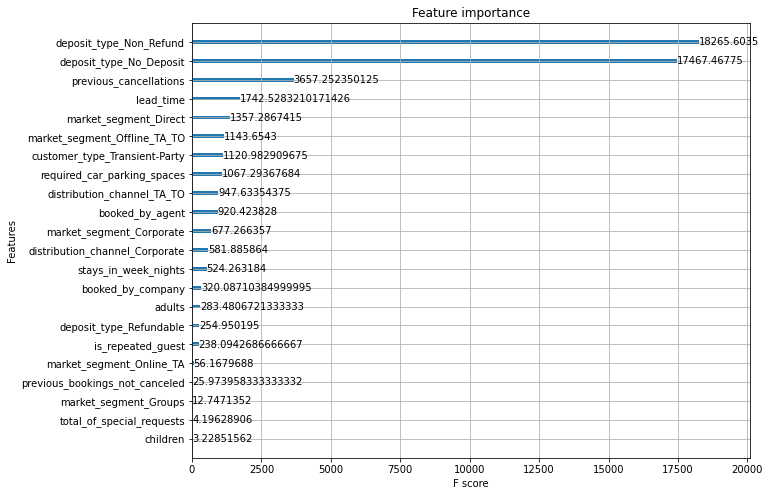

In [37]:
# Plot gain instead of weight
# Plot feature importance
# ”weight” is the number of times a feature appears in a tree
xgb.plot_importance(bookings_xgb_clf_2, importance_type='gain')
plt.show()

Here we see the ordering of features differs quite a bit between `gain` and `weight`! This implies that (1) feature importance can be subjective, and (2) the number of appearances a feature has on a tree is not necessarily correlated to how much gain it brings. For example, a binary variable has less of a chance to appear as many times as a continuous variable on a tree, since there are only two outputs. However, it can still be a powerful feature.

<p>What does deposit type none refund imply?<br>
Are none refund flights are cancelled more easily?</p>

#### **Plotting a decision tree from your model**

The second handy visualization function is `plot_tree()` which visually generates a decision tree in your model. Remember, there are multiple trees in the model.

It takes in the fitted XGBoost model, and with the `num_trees` parameter, you can indicate which tree you want to see. For example, if I have `n_estimator=3`, I can set the `num_trees` parameter as `0`, `1`, or `2` to see the first, second, or third tree, respectively.

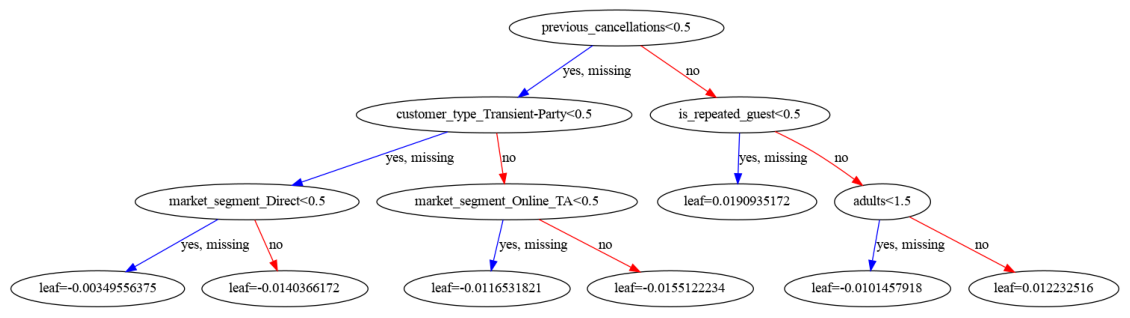

In [38]:
matplotlib.rcParams['figure.figsize'] = (20.0, 8)

# Plot the first tree
xgb.plot_tree(bookings_xgb_clf_2, n_estimator=5, num_trees=1)
plt.show()

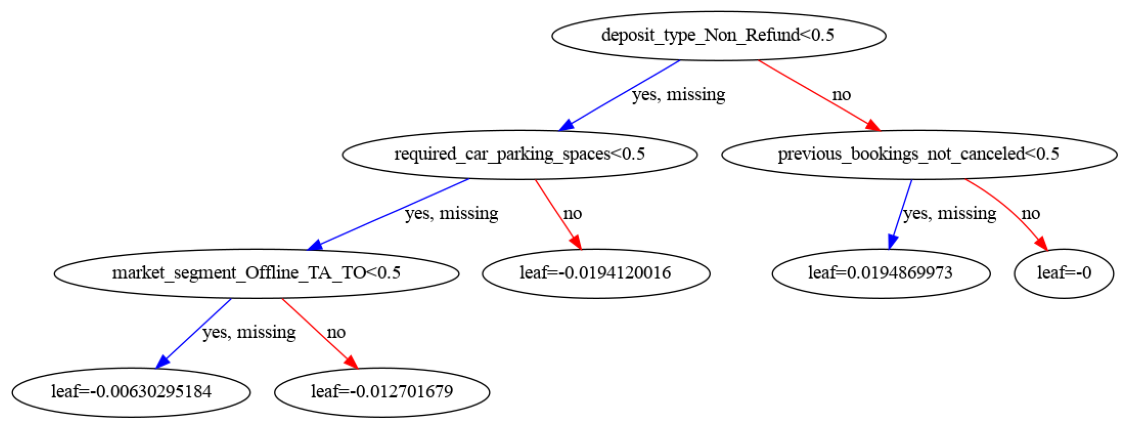

In [39]:
xgb.plot_tree(bookings_xgb_clf_2, n_estimator=5, num_trees=4)
plt.show()

The leaf output is the raw score. It's converted to a probability at the end of training.

There's a parameter called `rankdir`. We can set it to `LR` so the decision tree builds left to right, as opposed to top to bottom.

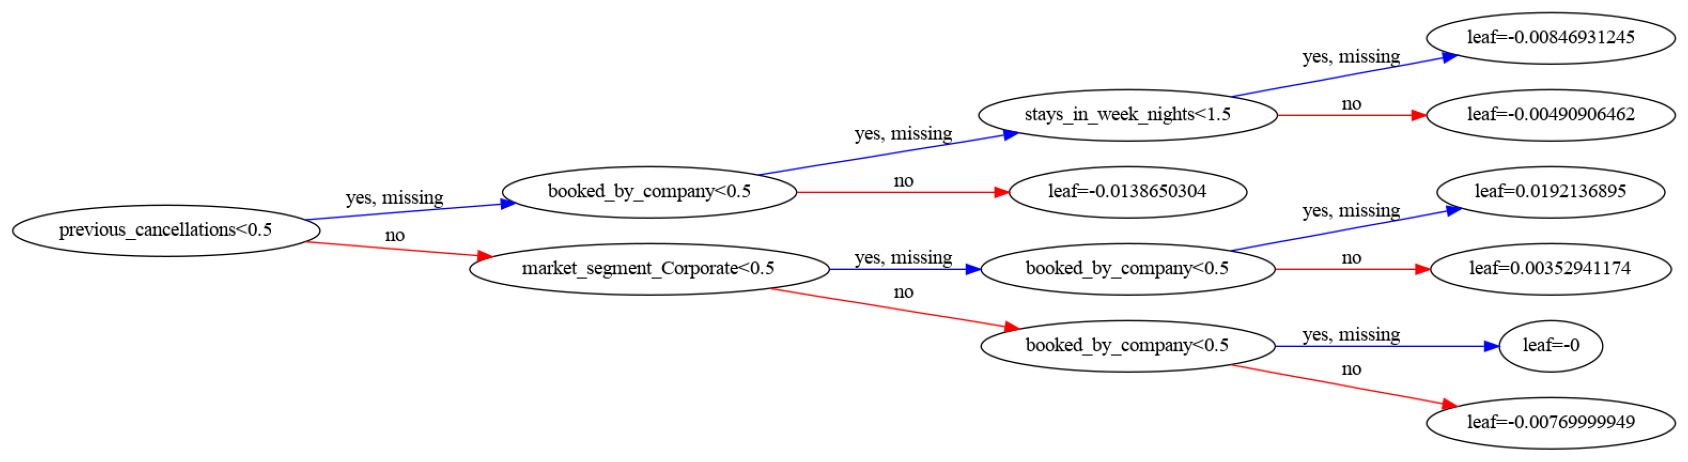

In [40]:
# Plot the tree left to right
matplotlib.rcParams['figure.figsize'] = (30, 20)

xgb.plot_tree(bookings_xgb_clf_2, rankdir='LR')
plt.show()

## **3. Digging into Parameters**

There are many parameters for our tree booster. We can see this in the documentation for [parameters for tree booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster).

In this section, we'll take a look at several important parameters and understand what they do.

For this session's purpose, we'll use `XGBClassifier()` with **25 boosting** rounds to avoid long training times. 

In [41]:
# from sklearn.metrics import accuracy_score

begin_3 = time.time()

# Instantiate the XGBClassifier with 25 boosting rounds and error evaluation metric
book_xgb_clf_3 = xgb.XGBClassifier(n_estimators=25, eval_metric='error', max_depth=3)

book_xgb_clf_3.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])

preds_3 = book_xgb_clf_3.predict(X_test)

acc_3 = round(accuracy_score(y_test, preds_3), 4)


time.sleep(1)
end_3 = time.time()

print(f"Total runtime of book_xgb_clf_3 is: {round(end_3 - begin_3, 4)} seconds.")

Total runtime of book_xgb_clf_3 is: 34.5691 seconds.


In [42]:
print("Accuracy of model 3 with max depths of 3")
print("_________________________________________")
print(acc_3)
print(f'{acc_3*100}')

Accuracy of model 3 with max depths of 3
_________________________________________
0.8109
81.08999999999999


### Evaluation of results with error eval_metric

<p>
This section does the evaluation of results with error eval_metric.<br>
It produces the minimum error and a data frame of the errors.<br>
It uses the data frame to build line plots of the errors over the estimators.<br>
It generates the inputs for the plot.
</p>

<p>
It generalizes the evaluation with self-defined functions.<br>
In another step a class for evaluation called Evaluating_Errors is created.
</p>    

In [43]:
evals_result_3 = book_xgb_clf_3.evals_result()
evals_result_3_df = pd.DataFrame.from_dict(evals_result_3['validation_0'])
evals_result_3_df.head()

,error
0,0.235111
1,0.235111
2,0.235144
3,0.234674
4,0.234406


In [44]:
evals_result_3_min = \
evals_result_3_df[evals_result_3_df['error'] == evals_result_3_df['error'].min()]

evals_result_3_min

,error
21,0.188639


In [45]:
def eval_results(clf):
        clf = clf.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
        evals_result = clf.evals_result()
        evals_result_df = pd.DataFrame.from_dict(evals_result['validation_0'])
        evals_result_min = \
        evals_result_df[evals_result_df['error'] == evals_result_df['error'].min()]
        return evals_result_df, evals_result_min
    

In [46]:
evals_result_3_df_2, evals_result_3_min_2 = eval_results(book_xgb_clf_3)

In [47]:
evals_result_3_df_2.head()

,error
0,0.235111
1,0.235111
2,0.235144
3,0.234674
4,0.234406


In [48]:
evals_result_3_min_2

,error
21,0.188639


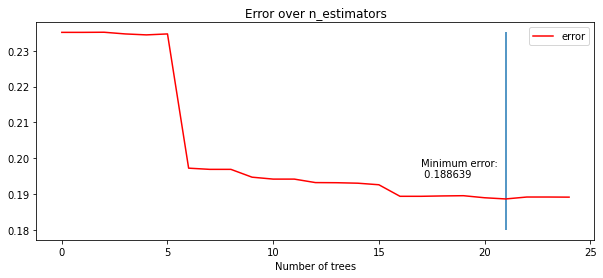

In [49]:
evals_result_3_df_2.plot(figsize=(10,4), color='red', title='Error over n_estimators')
plt.vlines(x=21 , ymin = 0.18, ymax=evals_result_3_df_2.max())
plt.annotate(s=f"Minimum error: \n {evals_result_3_min_2.iloc[0][0]}", \
             xy=(21-4, evals_result_3_df_2.min()+0.006))
plt.xlabel('Number of trees')
plt.show()

#### Plot errors with self-defined function

In [50]:
def plot_errors(evals, xvalue, ymin, ymax ):

        evals.plot(figsize=(10,4), color='red', title='Error over n_estimators')
        plt.vlines(x=xvalue, ymin = ymin, ymax=ymax)
        plt.annotate(s=f"Minimum error: \n {ymin} \n at estimator {xvalue}", \
                     xy=(xvalue-4, ymin + 0.006))
        plt.xlabel('Number of trees')
        plt.show()

In [ ]:
ymin_3 = evals_result_3_min_2.iloc[0][0]
print(ymin_3)

ymax_3 = evals_result_3_df_2.error.max()
print(ymax_3)

x_3 = evals_result_3_min_2.index[0]
print(x_3)

In [ ]:
plot_errors(evals=evals_result_3_df_2, xvalue=x_3 , ymin=ymin_3, ymax=ymax_3)

#### Func for inputs to plot errors

In [ ]:
def input_plot_errors(clf):
    evals_result_df, evals_result_min = eval_results(clf)
    
    ymin = evals_result_min.iloc[0][0]
    ymax = evals_result_df.error.max()
    xvalue = evals_result_min.index[0]
    
    return ymin, ymax, xvalue


In [ ]:
ymin_32, ymax_32, xvalue_32 = \
input_plot_errors(book_xgb_clf_3)

print(ymin_32, ymax_32, xvalue_32)

In [ ]:
plot_errors(evals=evals_result_3_df_2, xvalue=xvalue_32 , ymin=ymin_32, ymax=ymax_32)

#### Building a class for evaluating errors

In [ ]:
class Evaluating_Errors:
        def __init__(self, classifier):
                self.classifier = classifier
        
        def eval_results(self):  
            self.classifier = \
            self.classifier.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])
            evals_result = self.classifier.evals_result()
            evals_result_df = pd.DataFrame.from_dict(evals_result['validation_0'])
            evals_result_min = \
            evals_result_df[evals_result_df['error'] == evals_result_df['error'].min()]
            
            self.evals_result = evals_result
            self.evals_result_df = evals_result_df
            self.evals_result_min = evals_result_min
            
            return self.evals_result_df, self.evals_result_min 
        
        def input_plot_errors(self):
                self.ymin = self.evals_result_min.iloc[0][0]
                self.ymax = self.evals_result_df.error.max()
                self.xvalue = self.evals_result_min.index[0]
                return self.ymin, self.ymax, self.xvalue
            
        def plot_errors(self):

                self.evals_result_df.plot(figsize=(10,4), color='green', title='Error over n_estimators',
                                          linewidth=4)
                plt.vlines(x=self.xvalue, ymin = self.ymin, ymax=self.ymax)
                plt.annotate(s=f"Minimum error: \n {self.ymin} \n at estimator {self.xvalue}", \
                             xy=(self.xvalue-4, self.ymin + 0.006))
                plt.xlabel('Number of trees')
                plt.show()


In [ ]:
instance_evaluating_errors_3 = Evaluating_Errors(book_xgb_clf_3)

print(instance_evaluating_errors_3)
print(instance_evaluating_errors_3.classifier)

In [ ]:
evals_result_df_3_class, evals_result_min_3_class = \
instance_evaluating_errors_3.eval_results()

In [ ]:
print(evals_result_min_3_class)
evals_result_df_3_class.head()

In [ ]:
ymin_3_class, ymax_3_class, xvalue_3_class = \
instance_evaluating_errors_3.input_plot_errors()

for i in [ymin_3_class, ymax_3_class, xvalue_3_class]:
    print(i)

In [ ]:
instance_evaluating_errors_3.plot_errors()

### **Max depth**

_From XGBoost docs:_
> Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/max_depth.png?raw=true" width = "35%"> 
</p>

Let's see what happens when we increase the `max_depth` from 3 to 10.


In [ ]:
# Set max_depth to 10
max_depth=10

book_xgb_clf_4 = \
xgb.XGBClassifier(n_estimators=25, eval_metric='error', max_depth=max_depth)

# Fit the classifier to the training set
book_xgb_clf_4.fit(X_train, y_train)

# Predict the labels of the test set
preds_4 = book_xgb_clf_4.predict(X_test)

# Compute the accuracy
acc_4 = round(accuracy_score(y_test, preds_4), 4)

print("Accuracy of model 4 with max depths of 10")
print("_________________________________________")
print(acc_4)
print(f'{acc_4*100} %')

In [ ]:
print(acc_4 > acc_3)
print(round(acc_4 - acc_3, 4))

<p>
The assumption is not really confirmed.<br>
The model with depth of 10 did generate a slightly better accuracy on the y_test data.
</p>

In [ ]:
eval_results_df_4, eval_results_min_4 = eval_results(book_xgb_clf_4)


print(eval_results_min_4)
eval_results_df_4.head()

In [ ]:
eval_results_df_4.plot(figsize=(10,4), color='red', title='Error over n_estimators', linewidth=3)
plt.vlines(x=24 , ymin = 0.15, ymax=0.23)
plt.annotate(s=f"Minimum error: \n {eval_results_min_4.iloc[0][0]}", \
             xy=(24-4, 0.165352+0.006))
plt.show()

### **colsample_bytree**

_From XGBoost docs:_

> The subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.

Essentially, this lets us limit the number of columns used when constructing each tree. This adds randomness, making the model more robust to noise. The default is 1 (i.e. all the columns), let's try a smaller value.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/colsample_bytree.gif?raw=true" width = "55%"> 
</p>

In [ ]:
# Set colsample_bytree to 0.5 

colsample_bytree = 0.5
# Fit the classifier to the training set

book_xgb_clf_5 = \
xgb.XGBClassifier(n_estimators=25, eval_metric='error', max_depth=3,
                  colsample_bytree=colsample_bytree).fit(X_train, y_train)

# Predict the labels of the test set
preds_5 = book_xgb_clf_5.predict(X_test)

# Compute the accuracy
acc_5 = round(accuracy_score(y_test, preds_5),4)


print("Accuracy of model 5 with colsample_bytree = 0.5")
print("_________________________________________")
print(acc_5)
print(f'{acc_5*100} %')

In [ ]:
preds_5_df = pd.DataFrame(zip(y_test, preds_5), columns=['y_test', 'preds_5'])
preds_5_df['Correct_predictions?'] = preds_5_df.apply(correct_predictions, args=['preds_5'],
                                                      axis=1)
preds_5_df.head()

In [ ]:
preds_5_df['Correct_predictions?'].value_counts()

In [ ]:
acc_5_byhand = \
round((preds_5_df['Correct_predictions?'].sum() / preds_5_df['Correct_predictions?'].\
       shape[0])*100, 4)

print(acc_5_byhand)

#### Evaluating errors book_xgb_clf_5

In [ ]:
instance_evaluating_errors_5 = Evaluating_Errors(book_xgb_clf_5)

evals_result_df_5_class, evals_result_min_5_class = \
instance_evaluating_errors_5.eval_results()

print(evals_result_min_5_class)
evals_result_df_5_class.head()

In [ ]:
ymin_5_class, ymax_5_class, xvalue_5_class = \
instance_evaluating_errors_5.input_plot_errors()

for i in [ymin_5_class, ymax_5_class, xvalue_5_class]:
    print(i)
    

In [ ]:
instance_evaluating_errors_5.plot_errors()

In [ ]:
acc_comparison = \
pd.DataFrame([acc_3, acc_4, acc_5], index=['acc_3_md_3', 'acc_4_md_10', 'acc_5_bytree'], columns=['Accuracy'])

acc_comparison

In [ ]:
acc_comparison[acc_comparison['Accuracy'] == acc_comparison['Accuracy'].max()]

In [ ]:
acc_comparison.loc['acc_dmatrix'] = acc_dmatrix
acc_comparison.sort_values(by='Accuracy', ascending=False)

<p>
A combination of bytree and md improves the result.
</p>

In [ ]:
# Set colsample_bytree to 0.5 
colsample_bytree = 0.5
# Fit the classifier to the training set

book_xgb_clf_6 = \
xgb.XGBClassifier(n_estimators=25, eval_metric='error', max_depth=10,
                  colsample_bytree=colsample_bytree).fit(X_train, y_train)

# Predict the labels of the test set
preds_6 = book_xgb_clf_6.predict(X_test)

# Compute the accuracy
acc_6 = round(accuracy_score(y_test, preds_6),4)


print("Accuracy of model 6 with colsample_bytree = 0.5 and max depth = 10")
print("_________________________________________")
print(acc_6)
print(f'{acc_6*100} %')

#### Evaluating errors book_xgb_clf_6

In [ ]:
instance_evaluating_errors_6 = Evaluating_Errors(book_xgb_clf_6)

evals_result_df_6_class, evals_result_min_6_class = \
instance_evaluating_errors_6.eval_results()

print(evals_result_min_6_class)
evals_result_df_6_class.head()

ymin_6_class, ymax_6_class, xvalue_6_class = \
instance_evaluating_errors_6.input_plot_errors()

for i in [ymin_6_class, ymax_6_class, xvalue_6_class]:
    print(i)

instance_evaluating_errors_6.plot_errors()  


In [ ]:
acc_comparison.loc['acc_6_bytree_md_10'] = acc_6
acc_comparison

We can also limit the number of columns used by every depth level or node of our tree.

_From XGBoost docs:_

> `colsample_bylevel` is the subsample ratio of columns for each level. Subsampling occurs once for every new depth level reached in a tree. Columns are subsampled from the set of columns chosen for the current tree.

> `colsample_bynode` is the subsample ratio of columns for each node (split). Subsampling occurs once every time a new split is evaluated. Columns are subsampled from the set of columns chosen for the current level.

### **subsample**

_From XGBoost docs:_

> - Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees and this will prevent overfitting. 
> - Subsampling will occur once in every boosting iteration.
> - range: (0,1]

Default is 1, let's try 0.75. 

This means each of our trees will get a random sampling of 75% of our training data. Each tree will train on different portions of data which adds randomness (similar to `colsample_bytree`). 

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/subsample.gif?raw=true" width = "55%"> 
</p>

However, we don't want this too low if we don't have many trees, because our model will underfit from not seeing as much data.

In [ ]:
# Set subsample to 0.75 
subsample = 0.75

# Fit the classifier to the training set
book_xgb_clf_7 = \
xgb.XGBClassifier(n_estimators=25, eval_metric='error', max_depth=10,
                  colsample_bytree=colsample_bytree, subsample=subsample).fit(X_train, y_train)

# Predict the labels of the test set
preds_7 = book_xgb_clf_7.predict(X_test)

In [ ]:
# Compute the accuracy
acc_7 = round(accuracy_score(y_test, preds_7), 4)
print(acc_7)

#### Plot errors book_xgb_clf_7

In [ ]:
eval_results_df_7, eval_results_min_7 = eval_results(book_xgb_clf_7)


print(eval_results_min_7)

print(eval_results_min_7.iloc[0][0])
eval_results_df_7.head()

In [ ]:
ymin_7 = eval_results_min_7.iloc[0][0]
print(ymin_7)

ymax_7 = eval_results_df_7.error.max()
print(ymax_7)

x_7 = eval_results_min_7.index[0]
print(x_7)

In [ ]:
plot_errors(evals=eval_results_df_7, xvalue=x_7 , ymin=ymin_7, ymax=ymax_7)

In [ ]:
acc_comparison.loc['subsample'] = acc_7
acc_comparison

<p>
This did not improve the accuracy.
</p>

### **gamma**

_From XGBoost docs:_
> - Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger gamma is, the more conservative the algorithm will be.
> - range: [0,∞]


This decides whether a node will split based on the expected loss reduction after the split. `gamma` represents the minimum loss reduction required for a node to split.

<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/gamma.png?raw=true" width = "45%"> 
</p>

Increasing `gamma` = less splits = less complexity

The default is 0, so in our case, nodes have always split until the maximum depth. Let's increase it to 0.25.




In [ ]:
# Set gamma to .25 
gamma=0.25

# Fit the classifier to the training set
book_xgb_clf_8 = \
xgb.XGBClassifier(n_estimators=25, max_depth=10, colsample_bytree=0.5, eval_metric='error',
                  gamma=0.25).\
                  fit(X_train, y_train)

# Predict the labels of the test set
preds_8 = book_xgb_clf_8.predict(X_test)


In [ ]:
# Compute the accuracy
acc_8 = round(accuracy_score(y_test, preds_8), 5)
print(acc_8)

<p>This is an improvement in accuracy.</p>

In [ ]:
acc_comparison.loc['gamma'] = acc_8

print(acc_comparison[acc_comparison.Accuracy == acc_comparison.Accuracy.max()])

#### Plot errors book_xgb_clf_8

In [ ]:
instance_evaluating_errors_8 = Evaluating_Errors(book_xgb_clf_8)

evals_result_df_8_class, evals_result_min_8_class = \
instance_evaluating_errors_8.eval_results()

print(evals_result_min_8_class)
evals_result_df_8_class.head()

ymin_8_class, ymax_8_class, xvalue_8_class = \
instance_evaluating_errors_8.input_plot_errors()

for i in [ymin_8_class, ymax_8_class, xvalue_8_class]:
    print(i)

instance_evaluating_errors_8.plot_errors()  


In [ ]:
acc_comparison.sort_values(by='Accuracy', ascending=False)

### **Learning Rate (aka eta)**

_From XGBoost docs:_
> - Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
> - range: [0,1]

The learning rate affects how quickly a model learns.

Gradient boosting works by sequentially adding weak learners to the model. Each new weak learner attempts to correct the residual errors from the preceding trees. This make the model very susceptible to overfitting. Learning rate can help slow down learning by shrinking the resulting weights of the current tree before passing them on to the next tree.

The learning rate of our model defaults to 0.3. What happens if we change it to 0.1?

In [ ]:
# Set learning rate to .1
learning_rate=0.1

# Fit the classifier to the training set
book_xgb_clf_9 = \
xgb.XGBClassifier(n_estimators=25, max_depth=10, eval_metric='error', gamma=gamma,
                  colsample_bytree=0.5, learning_rate=learning_rate).fit(X_train, y_train)

# Predict the labels of the test set
preds_9 = book_xgb_clf_9.predict(X_test)

In [ ]:
# Compute the accuracy
acc_9 = round(accuracy_score(y_test, preds_9), 5)

#### Plot errors book_xgb_clf_9

In [ ]:
eval_results_df_9, eval_results_min_9 = eval_results(book_xgb_clf_9)


print(eval_results_min_9)

print(eval_results_min_9.iloc[0][0])
eval_results_df_9.head()

In [ ]:
ymin_9 = eval_results_min_9.iloc[0][0]
print(ymin_9)

ymax_9 = eval_results_df_9.error.max()
print(ymax_9)

x_9 = eval_results_min_9.index[0]
print(x_9)

In [ ]:
plot_errors(evals=eval_results_df_9, xvalue=x_9 , ymin=ymin_9, ymax=ymax_9)

In [ ]:
acc_comparison.loc['learning_rate'] = acc_9
acc_comparison.sort_values(by='Accuracy', ascending=False)

The learning rate and the number of trees should be tuned together. If we decrease the learning rate, we need to make sure we have enough trees to learn something and avoid severely underfitting. **Therefore, a low learning rate will require more boosting rounds.**

In [ ]:
# Fit the classifier to the training set
book_xgb_clf_10 = \
xgb.XGBClassifier(n_estimators=50, max_depth=10, eval_metric='error', gamma=gamma,
                  colsample_bytree=0.5, learning_rate=learning_rate).fit(X_train, y_train)

# Predict the labels of the test set
preds_10 = book_xgb_clf_10.predict(X_test)

In [ ]:
# Compute the accuracy
acc_10 = round(accuracy_score(y_test, preds_10), 5)
acc_10

#### Evaluating errors book_xgb_clf_10

In [ ]:
instance_evaluating_errors_10 = Evaluating_Errors(book_xgb_clf_10)

evals_result_df_10_class, evals_result_min_10_class = \
instance_evaluating_errors_10.eval_results()

print(evals_result_min_10_class)
evals_result_df_10_class.head()

ymin_10_class, ymax_10_class, xvalue_10_class = \
instance_evaluating_errors_10.input_plot_errors()

for i in [ymin_10_class, ymax_10_class, xvalue_10_class]:
    print(i)

instance_evaluating_errors_10.plot_errors()  


In [ ]:
acc_comparison.loc['learning_rate_boost_50'] = acc_10
acc_comparison.sort_values(by='Accuracy', ascending=False)

<p>
Adding more estimators or trees combined with the learning rate of 0.1 improved the result, but
did not achieved the best result.
</p>

### **reg_alpha**

_From XGBoost docs:_
> L1 regularization term on weights. Increasing this value will make model more conservative.

L1 is often referred to as **lasso regression**. It's a foundational regularization technique, meaning it aims to reduce overfitting by discouraging complex models. In the case of gradient boosting, L1 does this by adding penalties on leaf weights. Increasing `reg_alpha` drives base learners' leaf weights towards 0.

Default is 0, meaning there is no alpha regularization in our model currently. Let's activate L1 with a value of `0.01`.

In [ ]:
# Conservative means less prone to overfitting?
# set reg_alpha to .1 
reg_alpha = 0.1

# Fit the classifier to the training set
# Fit the classifier to the training set
book_xgb_clf_11 = \
xgb.XGBClassifier(n_estimators=50, max_depth=10, eval_metric='error', gamma=gamma,
                  colsample_bytree=0.5, learning_rate=learning_rate, 
                  reg_alpha=reg_alpha).fit(X_train, y_train)

# Predict the labels of the test set
preds_11 = book_xgb_clf_11.predict(X_test)
print(preds_11[:5])

# Compute the accuracy
acc_11 = accuracy_score(y_test, preds_11)
print(acc_11)

**L2**, aka ridge regression, is also available with the parameter `reg_lambda`. L2 is known for having smoother penalty then L1. This means leaf weights smoothly decrease rather with less risk of sparsity in the leaf weights. So, make sure to try our different regularization techniques! 

#### Evaluating errors of model book_xgb_clf_11

In [ ]:
instance_evaluating_errors_11 = Evaluating_Errors(book_xgb_clf_11)

evals_result_df_11_class, evals_result_min_11_class = \
instance_evaluating_errors_11.eval_results()

print(evals_result_min_11_class)
evals_result_df_11_class.head()

ymin_11_class, ymax_11_class, xvalue_11_class = \
instance_evaluating_errors_11.input_plot_errors()

for i in [ymin_11_class, ymax_11_class, xvalue_11_class]:
    print(i)

instance_evaluating_errors_11.plot_errors()  


Let's take a look at our resulting parameters after we manually changed them.

In [ ]:
# Print the model parameters
book_xgb_clf_11

In [ ]:
book_xgb_clf_11.get_xgb_params()

There are a lot of possible parameters combinations. We can't manually tune and pick them.

## **4. Cross validation**

<p>
Cross validation is a robust method for estimating the performance of the model of unseen
data.
For this reason the method generates many non-overlapping train/test-splits on the training data.
It reports the average test-set performance across all generated data splits.
</p>

In [ ]:
# X_train, X_test, y_train, y_test

DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_train

In [ ]:
book_cv_clf =   xgb.XGBClassifier(missing=9999999999,
                max_depth = 7,
                n_estimators=5,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                seed=1301)

In [ ]:
book_cv_clf_params = book_cv_clf.get_xgb_params()
print(book_cv_clf_params)

In [ ]:
book_cv_results = \
xgb.cv(dtrain=DM_train, params=book_cv_clf_params, nfold=4, num_boost_round=10,
       metrics=["error"], early_stopping_rounds=50, stratified=True, seed=5698)

In [ ]:
book_cv_results

In [ ]:
book_cv_results.describe()

In [ ]:
book_cv_results_min, book_cv_results_max = \
book_cv_results["test-error-mean"].aggregate(['min', 'max'])

In [ ]:
print(f"book_cv_results_min: {book_cv_results_min}")
print(f"book_cv_results_max: {book_cv_results_max}")

In [ ]:
book_cv_testerror_mean_df = pd.DataFrame(book_cv_results["test-error-mean"])
book_cv_testerror_mean_df['accuracy'] = 1 - book_cv_testerror_mean_df['test-error-mean']
book_cv_testerror_mean_df.head()

In [ ]:
book_cv_testerror_min_index = \
book_cv_testerror_mean_df[book_cv_testerror_mean_df['test-error-mean'] ==  book_cv_results_min]

book_cv_testerror_max_index = \
book_cv_testerror_mean_df[book_cv_testerror_mean_df['test-error-mean'] ==  book_cv_results_max]

In [ ]:
print(book_cv_testerror_max_index)

In [ ]:
print(book_cv_testerror_min_index)

print(type(book_cv_testerror_min_index))
print(book_cv_testerror_min_index.info())



In [ ]:
book_cv_testerror_min_index.iloc[:,1]
book_cv_testerror_min_index.iloc[:,1].values

In [ ]:
acc_comparison.loc['cross_validation'] = book_cv_testerror_min_index.iloc[:,1].values
acc_comparison.sort_values(by='Accuracy', ascending=False)

In [ ]:
book_cv_testerror_mean_df[['test-error-mean', 'accuracy']].\
plot(linewidth=5, color=['darkmagenta', 'green'], 
     figsize=(6,5))
plt.show()

In [ ]:
time_book_cv_clf_begin = time.time()

book_cv_clf.fit(X_train, y_train, eval_metric='auc')

time.sleep(1)
time_book_cv_clf_end = time.time()
print(f"Total runtime of book_cv_clf.fit is: {round(time_book_cv_clf_end  - time_book_cv_clf_begin, 4)} seconds.")

In [ ]:
book_cv_clf_probas = book_cv_clf.predict_proba(X_train)

In [ ]:
print('Overall AUC:', roc_auc_score(y_train, book_cv_clf_probas[:,1]))

In [ ]:
print('Predict the probabilities based on features in the test set')
pred = book_cv_clf.predict_proba(X_test, ntree_limit=10)


In [ ]:
pred_df = pd.DataFrame({"ID":y_test.index, "TARGET":pred[:,1]})
pred_df.head()

## **5. Hyperparameter tuning with Random Search and Grid Search**

Grid search and random search are the most popular methods for hyperparameter tuning. However, grid search can get computationally expensive if you are searching over a large hyperparameter space and dealing with multiple hyperparameters. This is why we'll use random search because it doesn't try all the hyperparameter values. In random search, a fixed number of hyperparameter settings is sampled from specified probability distributions.

XGBoost doesn't have a built-in gridsearch function, so we need to use `scikit-learn`'s [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html). This means we'll have to use `XGBClassifier()` because it's `scikit-learn` compatible.


<p align="center">
<img src="https://github.com/datacamp/Machine-Learning-With-XGboost-live-training/blob/master/assets/randomized_search_1.gif?raw=true" width = "50%"> 
</p>


<br>

The `RandomizedSearchCV()` function takes in the following arguments:

- `estimator`: The estimator being fit, here it's XGBoost.
- `param_distributions`: Unlike `params` - this is the distribution of possible hyperparameters to use.
- `cv`: Number of cross-validation iterations
- `n_iter`: Number of hyperparameter combinations to choose from
- `verbose`: Prints more output

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define a parameter grid
booksrandom_paramgrid_1 = {
    # max_depth: values from 3 to 12
    'max_depth':np.arange(3,13),
    # alpha: values 0, .001, .01, .1
    'alpha':[0, .001, .01, .1],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample':[0.25,0.5,0.75, 1],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate':np.linspace(0.01, 0.5, 10),
    # n_estimators: values 10, 25, 40
    'n_estimators':[10, 25, 40]
}

booksrandom_paramgrid_2 = {
    # max_depth: values from 3 to 12
    'max_depth':np.arange(3,6),
    # alpha: values 0, .001, .01, .1
    'alpha':[0, .001],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample':[0.25,0.5],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate':np.linspace(0.01, 0.5, 3),
    # n_estimators: values 10, 25, 40
    'n_estimators':[10, 25]
}

In [ ]:
# Insantiate XGBoost Clasifier 
randomsearch_clf = \
xgb.XGBClassifier(eval_metric='error', verbosity=0)


In [ ]:
# Instantiate RandomizedSearchCV()
bookings_randomsearch = \
RandomizedSearchCV(estimator=randomsearch_clf, 
                   param_distributions=booksrandom_paramgrid_2,
                   n_iter=25,
                   scoring='accuracy', cv=4, verbose=1)


In [ ]:
begin_randomsearch = time.time()

# Train the model on the training set
bookings_randomsearch.fit(X_gridsearch, y_gridsearch)

time.sleep(1)
end_randomsearch = time.time()

print(f"Total runtime of book_xgb_clf_3 is: {round(begin_randomsearch - begin_randomsearch, 4)} seconds.")

In [ ]:

# Print the best parameters and highest accuracy
bookings_randomsearch_bestparams = bookings_randomsearch.best_params_
print(bookings_randomsearch_bestparams)
print(f'Best parameters of random search: {bookings_randomsearch_bestparams}')

bookings_randomsearch_bestscore = bookings_randomsearch.best_score_
print(f'Best accuracy of random search: {bookings_randomsearch_bestscore}')

In [ ]:
joblib.dump(bookings_randomsearch, 'bookings_randomsearch.sav')

In [ ]:
acc_comparison.loc['bookings_randomsearch_bestscore'] = bookings_randomsearch_bestscore
acc_comparison.sort_values(by='Accuracy', ascending=False)

## Gridsearch

In [ ]:
# from sklearn.model_selection import GridSearchCV

bookings_param_grid = \
{
'learning_rate': [0.001, 0.1, 0.5, 0.9],
'n_estimators': [50,100],
'subsample':[0.3, 0.5, 0.9],
'max_depth':[5, 10, 20],
'gamma':[0.2, 0.4, 0.6],
'reg_alpha':[0.1, 0.02, 0.05, 0.1, 0.2]
}

In [ ]:
bookings_param_grid_2 = \
{
'learning_rate': [0.001, 0.1, 0.5],
'n_estimators': [25,50],
'subsample':[0.3,  0.9],
'max_depth':[5, 20],
'gamma':[0.2, 0.6],
'reg_alpha':[0.1, 0.05, 0.1]
}

In [ ]:
bookings_param_grid_3 = \
{
'learning_rate': [0.001, 0.1],
'n_estimators': [10,15],
'subsample':[0.3, 0.5],
'max_depth':[5, 10],
'gamma':[0.2, 0.4],
'reg_alpha':[0.1, 0.05]
}

bookings_param_grid_4 = \
{
'learning_rate': [0.001],
'n_estimators': [10],
'subsample':[0.3],
'max_depth':[5],
'gamma':[0.2, 0.4],
'reg_alpha':[0.4]
}

bookings_param_grid_5 = \
{
'learning_rate': [0.001],
'n_estimators': [10],
'subsample':[0.3],
'max_depth':[5],
'gamma':[0.2],
'reg_alpha':[0.4],
'eval_metric':'error', 
'verbosity':0
}

In [ ]:
gridsearch_clf = xgb.XGBClassifier(eval_metric='error', verbosity=0)

In [ ]:
bookings_grid = \
GridSearchCV(estimator=gridsearch_clf, param_grid=bookings_param_grid_4, scoring='accuracy',
             cv=4)

In [ ]:
begin_grid = time.time()

bookings_grid_fit = \
bookings_grid.fit(X_train, y_train)

time.sleep(1)
end_grid = time.time()

print(f"Total runtime of book_xgb_clf_3 is: {round(begin_grid - begin_grid, 4)} seconds.")

In [ ]:
bookings_grid_bestparams = bookings_grid.best_params_
print(f'Best parameters generated of the cross validation model: {bookings_grid_bestparams}')

In [ ]:
bookings_grid_bestscore = bookings_grid.best_score_
print(f'Best accuracy generated: \n {bookings_grid_bestscore}')

In [ ]:
joblib_bookings_grid = joblib.dump(bookings_grid , 'bookings_grid.sav')
joblib_bookings_grid

In [ ]:
acc_comparison.loc['bookings_grid_bestscore'] = bookings_grid_bestscore 
acc_comparison.sort_values(by='Accuracy', ascending=False)

<p>The acc above is not a good improvement.<br>
As XGBoost is an ensemble technique the number of estimators or trees is essential.<br>
The acc increases with the number of estimators up to a point.<br>
A more technical point: the number of parameters tested increases the need for computing power.<br>
Otherwise like here it takes long to test the different combinations by grid search.<br>
Practically a cloud computing solution like AWS EC2 could be considered and more computing resource instances added.<br>

In [ ]:
book_with_bestparams = xgb.XGBClassifier(eval_metric='error', verbosity=0,
                                         gamma= 0.4, learning_rate=0.001, max_depth=5, 
                                         n_estimators=10, reg_alpha=0.4, subsample=0.3)

In [ ]:
book_with_bestparams.fit(X_train, y_train)
preds_book_with_bestparam = book_with_bestparams.predict(X_test)
acc_book_with_bestparam = accuracy_score(y_test, preds_book_with_bestparam)

print(acc_book_with_bestparam)

In [ ]:
acc_comparison.loc['acc_book_with_bestparam'] = acc_book_with_bestparam
acc_comparison.sort_values(by='Accuracy', ascending=False)

### Machine learning pipelines with XGBoost

<p>
The process:<br>
Inputs: scaler, clf -> pipeline -> cross validation

<ul>
  <li>Inputs can be every scikit compatible method.</li>
  <li>Typical methods are estimators (models) or preprocessing methods like scaling or label encoding.
    </li>
  <li>The pipeline is a tuple.</li>
  <li>Compatible validation methods: cross validation, cross val score, grid search, random grid search.</li>
</ul> 

In [ ]:
X_gridsearch_dtypes = X_gridsearch.dtypes

print(type(X_gridsearch_dtypes))
print(X_gridsearch_dtypes[:5])

In [ ]:
book_pipe = Pipeline([('scaler', StandardScaler()), ('xgb_model', xgb.XGBClassifier())])

In [ ]:
time_begin_book_cross_val_scores = time.time()

book_cross_val_scores = \
cross_val_score(book_pipe, X_gridsearch, y_gridsearch, scoring='accuracy', 
                cv=5 )

time.sleep(1)
time_end_book_cross_val_scores = time.time()

print(f"Total runtime of the program is {time_end_book_cross_val_scores - time_begin_book_cross_val_scores}.")

In [ ]:
print(book_cross_val_scores)

book_cross_val_scores_mean = np.mean(book_cross_val_scores)
print(f'Mean accuracy: {book_cross_val_scores_mean}')

In [ ]:
value_for_pred_1 = X_gridsearch.iloc[15,:]
cross_val_score.predict(value_for_pred_1)

In [ ]:
acc_comparison.loc['book_cross_val_scores_mean'] = book_cross_val_scores_mean
acc_comparison.sort_values(by='Accuracy', ascending=False)

### Hyper tuning an XGBoost model in a pipeline with Gridsearch

<p>
Here are coming a number of methods together:
</p>

<ul>
  <li>Pipeline with scaling and estimator</li>
  <li>A param grid with parameters adjusted to the estimator.</li>
  <li>Gridsearch</li>
</ul> 

<p>
Luckily Gridsearch understand pipes and param grids.
</p>

In [ ]:
# The scaler stays the same
book_pipe = Pipeline([('scaler', StandardScaler()), ('xgb_model', xgb.XGBClassifier())])

# The grid is slightly changed. The name needs the model and then double underscores
bookings_param_grid_200 = [{'xgb_model__learning_rate': [0.001, 0.01]}]

bookings_param_grid_300 = \
[{
'xgb_model__learning_rate': [0.001, 0.01],
'xgb_model__n_estimators': [10, 15],
'xgb_model__subsample':[0.3, 0.6],
'xgb_model__max_depth':[5, 10],
'xgb_model__reg_alpha':[0.4, 0.6]
}]

In [ ]:
book_pipe_gscv  = GridSearchCV(estimator=book_pipe,
                  param_grid=bookings_param_grid_200,
                  scoring='accuracy',
                  cv=10) 

#### What parameters are available for tuning?
<p>
The syntax for the param grid adjusted to the estimator is:<br>
estimator_name__parameter<br>
The syntax uses a double underscore between name and parameter.<br>
In the example above this is:<br>
'xgb_model__learning_rate'
</p>

<p>
The double underscores make all the different, see
<a href="https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline" target="_blank">Stack</a>
</p>


In [ ]:
keys_pipe_grid = list(book_pipe_gscv.get_params().keys())
print(type(keys_pipe_grid ))
keys_pipe_grid [:10]


In [ ]:
t_b_1 = time.time()

book_pipe_gscv.fit(X_gridsearch, y_gridsearch)

time.sleep(1)
t_b_2 = time.time()
# total time taken
print(f"Total runtime of the program is {t_b_2 - t_b_1}")

In [ ]:
book_pipe_gscv_bestparams = book_pipe_gscv.best_params_
print(f'Best parameters generated of the cross validation model: {book_pipe_gscv_bestparams}')

In [ ]:
book_pipe_gscv_bestscore = book_pipe_gscv.best_score_
print(f'Best accuracy generated: \n {book_pipe_gscv_bestscore}')

In [ ]:
joblib.dump(book_pipe_gscv , 'book_pipe_gscv.sav')

In [ ]:
joblib_model_book_pipe_gscv = joblib.load('book_pipe_gscv.sav')

In [ ]:
joblib_model_book_pipe_gscv 

In [ ]:
acc_comparison.loc['book_pipe_gscv_bestscore'] = book_pipe_gscv_bestscore
acc_comparison.sort_values(by='Accuracy', ascending=False)